In [159]:
import requests
import matplotlib.pyplot as plt
from IPython.display import Image
import pandas as pd
import json
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster
from shapely.geometry import Point
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from patsy import dmatrices

### Establishing endpoint and parameters, submit api request, and converting to json

In [160]:
endpoint = "https://data.nashville.gov/resource/2u6v-ujjs.json?$limit=50000"

params = {'$where' : "incident_reported between '2021-01-13T00:00:00.000' and '2021-06-30T00:00:00.000'", 
}

In [161]:
response = requests.get(endpoint, params)

In [162]:
res = response.json()

### Converting response to a dataframe and cleanup
##### Modified 'incident_reported' column to only include date 
###### Converted latitude and longitude from objects to floats

In [163]:
res_trimmed = pd.DataFrame(res, columns=['incident_reported', 'offense_description', 'latitude', 'longitude', 'zip_code'])

res_trimmed['incident_reported'] = res_trimmed['incident_reported'].str.split("T", expand=True)[0]

burglary_reports = res_trimmed[res_trimmed['offense_description'].str.contains('BURGLARY- AGGRAVATED')]

burglary_reports.head()

,incident_reported,offense_description,latitude,longitude,zip_code
199,2021-01-13,BURGLARY- AGGRAVATED,36.06,-86.95,NaN
310,2021-01-14,BURGLARY- AGGRAVATED,36.19,-86.75,NaN
434,2021-01-14,BURGLARY- AGGRAVATED,36.18,-86.75,NaN
450,2021-01-14,BURGLARY- AGGRAVATED,36.04,-86.73,NaN
495,2021-01-14,BURGLARY- AGGRAVATED,36.16,-86.85,NaN


In [164]:
burglary_reports[['latitude', 'longitude']] = burglary_reports[['latitude', 'longitude']].apply(pd.to_numeric);

burglary_reports.shape

C:\Users\Conrad\anaconda3\envs\geospatial\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


(984, 5)

### Downloaded census tract data and uploaded code

In [165]:
census_tract = gpd.read_file('data/tl_2019-47_tract/tl_2019_47_tract.shp')
type(census_tract)

geopandas.geodataframe.GeoDataFrame

In [166]:
print(census_tract.crs)
census_tract.head()

epsg:4269


,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,47,165,021002,47165021002,210.02,Census Tract 210.02,G5020,S,30654374,207994,+36.3521602,-086.6464309,"POLYGON ((-86.69927 36.32775, -86.69923 36.327..."
1,47,165,020901,47165020901,209.01,Census Tract 209.01,G5020,S,23811766,3412697,+36.3483143,-086.4070907,"POLYGON ((-86.43949 36.35962, -86.43915 36.359..."
2,47,165,020300,47165020300,203,Census Tract 203,G5020,S,14629292,0,+36.5796910,-086.5114955,"POLYGON ((-86.53716 36.56852, -86.53713 36.568..."
3,47,165,020902,47165020902,209.02,Census Tract 209.02,G5020,S,9756715,0,+36.3724350,-086.4411274,"POLYGON ((-86.47106 36.38238, -86.47081 36.382..."
4,47,165,020800,47165020800,208,Census Tract 208,G5020,S,10235406,37743,+36.4005117,-086.4528100,"POLYGON ((-86.48786 36.37320, -86.48783 36.373..."


In [167]:
#leg_kwds = {'title': 'Census Tracts', 'loc':'upper left', 
#            'bbox_to_anchor': (0, 0), 'ncol': 9}

#census_tract.plot(column = 'NAME', figsize=(15, 15), edgecolor = 'black',
#                 legend = True, legend_kwds = leg_kwds, cmap = 'terrain')

### Created appropriate 'geometry' column with Point(long, lat) format and converted to GeoDataFrame

In [168]:
burglary_reports['geometry'] = burglary_reports.apply(lambda x: Point((x.longitude,
                                                                      x.latitude)),
                                                     axis=1)

burglary_reports.head()

C:\Users\Conrad\AppData\Local\Temp/ipykernel_26144/3948901756.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  burglary_reports['geometry'] = burglary_reports.apply(lambda x: Point((x.longitude,


,incident_reported,offense_description,latitude,longitude,zip_code,geometry
199,2021-01-13,BURGLARY- AGGRAVATED,36.06,-86.95,NaN,POINT (-86.95 36.06)
310,2021-01-14,BURGLARY- AGGRAVATED,36.19,-86.75,NaN,POINT (-86.75 36.19)
434,2021-01-14,BURGLARY- AGGRAVATED,36.18,-86.75,NaN,POINT (-86.75 36.18)
450,2021-01-14,BURGLARY- AGGRAVATED,36.04,-86.73,NaN,POINT (-86.73 36.04)
495,2021-01-14,BURGLARY- AGGRAVATED,36.16,-86.85,NaN,POINT (-86.84999999999999 36.16)


In [169]:
burglary_geo = gpd.GeoDataFrame(burglary_reports,
                               crs=census_tract.crs,
                               geometry = burglary_reports['geometry'])

### Paired down census_tract usable columns and joined with burglary_geo data

In [170]:
census_tract = census_tract[['COUNTYFP', 'TRACTCE', 'NAME', 'geometry']]
census_tract['COUNTYFP'] = census_tract['COUNTYFP'].apply(pd.to_numeric)
census_tract = census_tract[census_tract['COUNTYFP'] == 37]
census_tract.head()

,COUNTYFP,TRACTCE,NAME,geometry
27,37,010106,101.06,"POLYGON ((-86.83089 36.26570, -86.83016 36.265..."
36,37,010103,101.03,"POLYGON ((-86.91752 36.33976, -86.91747 36.339..."
37,37,010202,102.02,"POLYGON ((-86.82482 36.33225, -86.82480 36.332..."
38,37,010104,101.04,"POLYGON ((-86.97440 36.24991, -86.97244 36.252..."
63,37,013300,133,"POLYGON ((-86.86843 36.16436, -86.86836 36.164..."


In [171]:
burglary_by_tract = gpd.sjoin(burglary_geo, census_tract, op = 'within')

### Gets rid of duplicates in data and adjusts columns

In [172]:
burglary_by_tract.drop_duplicates(subset='geometry', inplace=True)
burglary_by_tract = burglary_by_tract.drop(columns='index_right')
burglary_by_tract = burglary_by_tract.rename(columns={'TRACTCE':'tract'})
burglary_by_tract.head()

,incident_reported,offense_description,latitude,longitude,zip_code,geometry,COUNTYFP,tract,NAME
199,2021-01-13,BURGLARY- AGGRAVATED,36.06,-86.95,NaN,POINT (-86.95000 36.06000),37,018407,184.07
14375,2021-03-05,BURGLARY- AGGRAVATED,36.07,-86.99,NaN,POINT (-86.99000 36.07000),37,018407,184.07
310,2021-01-14,BURGLARY- AGGRAVATED,36.19,-86.75,NaN,POINT (-86.75000 36.19000),37,011700,117
2779,2021-01-22,BURGLARY- AGGRAVATED,36.19,-86.74,NaN,POINT (-86.74000 36.19000),37,011700,117
434,2021-01-14,BURGLARY- AGGRAVATED,36.18,-86.75,NaN,POINT (-86.75000 36.18000),37,011900,119


### Creates polygon objects of tracts of only Davidson county

In [173]:
census_tract_names = burglary_by_tract['NAME']
census_tract_names = pd.DataFrame(census_tract_names)
polygon_nash = pd.merge(census_tract, census_tract_names, on = 'NAME')
polygon_nash.drop_duplicates(subset='NAME')

,COUNTYFP,TRACTCE,NAME,geometry
0,37,010106,101.06,"POLYGON ((-86.83089 36.26570, -86.83016 36.265..."
2,37,010104,101.04,"POLYGON ((-86.97440 36.24991, -86.97244 36.252..."
6,37,013300,133,"POLYGON ((-86.86843 36.16436, -86.86836 36.164..."
10,37,018102,181.02,"POLYGON ((-86.88737 36.11771, -86.88733 36.117..."
12,37,010602,106.02,"POLYGON ((-86.69530 36.25263, -86.69513 36.253..."
...,...,...,...,...
397,37,018904,189.04,"POLYGON ((-86.73805 36.06626, -86.73780 36.066..."
399,37,018905,189.05,"POLYGON ((-86.74457 36.05547, -86.74447 36.055..."
400,37,013601,136.01,"POLYGON ((-86.84383 36.16325, -86.84375 36.163..."
404,37,018301,183.01,"POLYGON ((-87.03820 36.09382, -87.03819 36.093..."


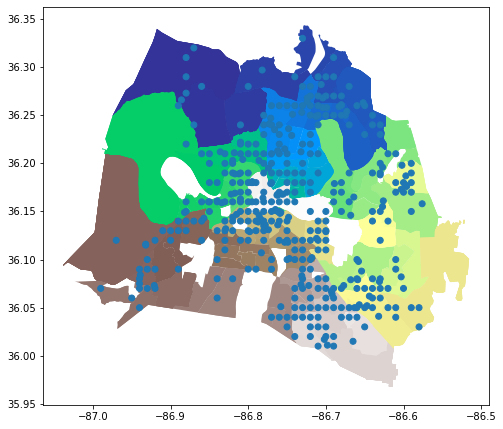

In [174]:
ax = polygon_nash.plot(column='TRACTCE', figsize = (8, 10), cmap='terrain')
burglary_by_tract.plot(ax = ax, column = 'offense_description')
plt.show();

### Imports Census data

In [175]:
with open('data/data_census.json') as fi:
    credentials = json.load(fi)
       
api_key = credentials['api_key']


In [176]:
endpoint_pop = "https://api.census.gov/data/2019/acs/acs5"
params_pop = {
       'get' : 'NAME,B01001_001E',
       'for' : 'tract:*',
       'in'  : ['state:47', 'county:037'],
       'key' : api_key
}

endpoint_income = "https://api.census.gov/data/2019/acs/acs5/subject"
params_income = {
       'get' : 'NAME,S1901_C01_012E',
       'for' : 'tract:*',
       'in'  : ['state:47', 'county:037'],
       'key' : api_key
}


In [177]:
response_pop = requests.get(endpoint_pop, params=params_pop)

response_income = requests.get(endpoint_income, params=params_income)

In [178]:
res_pop = response_pop.json()
population = pd.DataFrame(res_pop)
#changes column names
population.columns = population.iloc[0]
population = population[1:]
display(population.head())

res_income = response_income.json()
med_income = pd.DataFrame(res_income) 
#changes colum names 
med_income.columns = med_income.iloc[0]
med_income = med_income[1:]
display(med_income.head())

,NAME,B01001_001E,state,county,tract
1,"Census Tract 156.31, Davidson County, Tennessee",12176,47,037,015631
2,"Census Tract 158.04, Davidson County, Tennessee",4098,47,037,015804
3,"Census Tract 177.01, Davidson County, Tennessee",2466,47,037,017701
4,"Census Tract 177.02, Davidson County, Tennessee",5210,47,037,017702
5,"Census Tract 183.01, Davidson County, Tennessee",8254,47,037,018301


,NAME,S1901_C01_012E,state,county,tract
1,"Census Tract 156.31, Davidson County, Tennessee",75579,47,037,015631
2,"Census Tract 158.04, Davidson County, Tennessee",45129,47,037,015804
3,"Census Tract 177.01, Davidson County, Tennessee",134786,47,037,017701
4,"Census Tract 177.02, Davidson County, Tennessee",107813,47,037,017702
5,"Census Tract 183.01, Davidson County, Tennessee",87591,47,037,018301


### Merges census data together and renames columns

In [179]:
pop_and_income = pd.merge(population, med_income, how='inner')
pop_and_income = pop_and_income.rename(columns={'B01001_001E': 'population',
                                               'S1901_C01_012E':'median_income'})
pop_and_income.head()

,NAME,population,state,county,tract,median_income
0,"Census Tract 156.31, Davidson County, Tennessee",12176,47,037,015631,75579
1,"Census Tract 158.04, Davidson County, Tennessee",4098,47,037,015804,45129
2,"Census Tract 177.01, Davidson County, Tennessee",2466,47,037,017701,134786
3,"Census Tract 177.02, Davidson County, Tennessee",5210,47,037,017702,107813
4,"Census Tract 183.01, Davidson County, Tennessee",8254,47,037,018301,87591


In [243]:
burglaries_and_var = pd.merge(burglary_by_tract, pop_and_income, on='tract')
burglaries_and_var = burglaries_and_var.drop(columns=['latitude', 'longitude', 'zip_code','NAME_x','NAME_y'])
burglaries_and_var.head()

,incident_reported,offense_description,geometry,COUNTYFP,tract,population,state,county,median_income
0,2021-01-13,BURGLARY- AGGRAVATED,POINT (-86.95000 36.06000),37,018407,5001,47,037,105917
1,2021-03-05,BURGLARY- AGGRAVATED,POINT (-86.99000 36.07000),37,018407,5001,47,037,105917
2,2021-01-14,BURGLARY- AGGRAVATED,POINT (-86.75000 36.19000),37,011700,5971,47,037,68889
3,2021-01-22,BURGLARY- AGGRAVATED,POINT (-86.74000 36.19000),37,011700,5971,47,037,68889
4,2021-01-14,BURGLARY- AGGRAVATED,POINT (-86.75000 36.18000),37,011900,2530,47,037,51168


In [244]:
#tract_counts = pd.DataFrame(burglaries_and_var['tract'].value_counts())
tract_counts = pd.DataFrame(burglaries_and_var['tract'].value_counts())
tract_counts = tract_counts.rename(columns={'tract':'burglary_count'})

pop_income = pd.DataFrame(burglaries_and_var[['tract', 'population', 'median_income']])
pop_income = pop_income.set_index('tract')

tract_pop_income = pd.merge(pop_income, tract_counts, left_index=True, right_index=True)
tract_pop_income = tract_pop_income.drop_duplicates(keep='first')

tract_pop_income.reset_index(level=0, inplace=True)
tract_pop_income = tract_pop_income.rename(columns={'index': 'tract'})

tract_pop_income[['population', 'median_income']] = tract_pop_income[['population', 'median_income']].apply(pd.to_numeric)
tract_pop_income = tract_pop_income[tract_pop_income['population'] >= 0]
tract_pop_income = tract_pop_income[tract_pop_income['median_income'] >= 0]

tract_pop_income.head()

,tract,population,median_income,burglary_count
0,010104,2955,64844,4
1,010105,4435,64688,3
2,010106,3397,63864,2
3,010201,4157,62829,3
4,010301,3395,51918,1


In [250]:
tract_pop_income['burg_per_1000'] = ((tract_pop_income['burglary_count'] / tract_pop_income['population']) * 1000)
tract_pop_income['log_population'] = np.log(tract_pop_income['population'])
tract_pop_income.head()

,tract,population,median_income,burglary_count,burg_per_1000,log_population
0,010104,2955,64844,4,1.353638,7.991254
1,010105,4435,64688,3,0.676437,8.397283
2,010106,3397,63864,2,0.588755,8.130648
3,010201,4157,62829,3,0.721674,8.332549
4,010301,3395,51918,1,0.294551,8.130059


In [262]:
burg_base_pois =  (sm.GLM(endog = tract_pop_income['burglary_count'],
                              exog = sm.add_constant(tract_pop_income[[]]),
                              family = sm.families.Poisson(),
                              offset = tract_pop_income['log_population'])
                       .fit()
 )
burg_base_pois.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         burglary_count   No. Observations:                  144
Model:                            GLM   Df Residuals:                      143
Model Family:                 Poisson   Df Model:                            0
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -267.34
Date:                Sun, 10 Oct 2021   Deviance:                       129.67
Time:                        14:07:47   Pearson chi2:                     141.
No. Iterations:                     5   Pseudo R-squ. (CS):              0.000
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.3496      0.049   -149.361      0.000      -7.446      -7.253
==============================================================================
"""

In [263]:
burg_income_pois =  (sm.GLM(endog = tract_pop_income['burglary_count'],
                              exog = sm.add_constant(tract_pop_income['median_income']),
                              family = sm.families.Poisson(),
                              offset = tract_pop_income['log_population'])
                       .fit()
 )
burg_income_pois.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         burglary_count   No. Observations:                  144
Model:                            GLM   Df Residuals:                      142
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -258.55
Date:                Sun, 10 Oct 2021   Deviance:                       112.10
Time:                        14:07:58   Pearson chi2:                     116.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1149
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -6.8103      0.138    -49.177      0.000      -7.082      -6.539
median_income -8.807e-06    2.2e-06     -4.001      0.000   -1.31e-05   -4.49e-06
=================================================================================
"""

C:\Users\Conrad\anaconda3\envs\geospatial\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


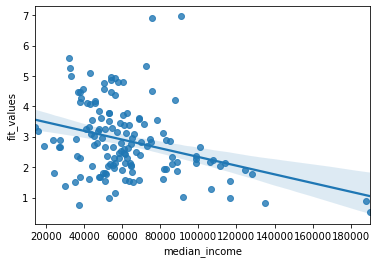

In [265]:
tract_pop_income['fit_values'] = burg_income_pois.fittedvalues

sns.regplot('median_income', 'fit_values',
                data = tract_pop_income);

In [266]:
#fill
np.exp(poisreg_burglaries.params['const'])
#full_like


1.1023287569419777

In [267]:
line = np.linspace(0, 3, num=200)

C:\Users\Conrad\anaconda3\envs\geospatial\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

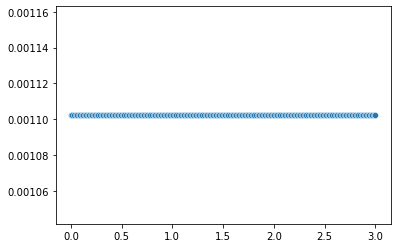

In [268]:
y = np.full_like(line, np.exp(burg_income_pois.params['const']))

sns.scatterplot(line, y)

numpy.linspace(start, stop, num=50, endpoint=True, retstep=False, dtype=None, axis=0)
numpy.full_like(a, fill_value, dtype=None, order='K', subok=True, shape=None)
np.exp(poisreg_burglaries.params['const'])

https://seaborn.pydata.org/generated/seaborn.regplot.html


In [269]:
expr = """burglary_count ~ median_income"""

y_train, X_train = dmatrices(expr, tract_pop_income, return_type='dataframe')

poisson_training_results = (sm.GLM(y_train, X_train, 
                                   family=sm.families.Poisson(),
                                   offset = tract_pop_income['log_population'])
                            .fit())                                    
display(poisson_training_results.summary())


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         burglary_count   No. Observations:                  144
Model:                            GLM   Df Residuals:                      142
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -258.55
Date:                Sun, 10 Oct 2021   Deviance:                       112.10
Time:                        14:08:02   Pearson chi2:                     116.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1149
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -6.8103      0.138    -49.177      0.000      -7.082      -6.539
median_income -8.807e-06    2.2e-06     -4.001      0.000   -1.31e-05   -4.49e-06
=================================================================================
"""

In [270]:
print(poisson_training_results.mu)
print(len(poisson_training_results.mu))

[1.84015849 2.76559151 2.13374034 2.63502465 2.36906241 3.5240911
 3.60507079 5.58109991 3.37574549 3.71109499 3.38100809 2.94710603
 3.08181335 2.67853844 3.77627789 2.7350592  2.14358055 4.56515872
 2.87929537 5.08725034 1.81303622 2.08700651 2.48149514 4.16143755
 3.25203102 2.30775559 3.0806472  3.58817505 2.02460922 1.77715711
 0.99503733 1.0328019  1.55438681 4.998683   1.9625119  4.4860736
 3.30783335 1.54219301 2.03729989 2.07845317 2.39945827 2.32570794
 2.88660238 5.25739358 1.66038983 1.37291452 1.809239   1.50231144
 1.59893107 3.17669484 2.47154093 1.58608627 3.63142398 3.42816245
 2.81343928 3.11333766 2.14599071 2.78887344 2.95187659 5.33362624
 4.91788607 4.15537586 2.77821409 4.09838623 1.57848426 4.45936404
 2.92410255 4.96889599 2.17635742 4.06291464 3.44916115 3.77589331
 4.77224564 1.90411227 2.67602663 4.87862946 3.15938776 6.89832225
 1.14770623 4.47842979 2.31591627 3.03581318 2.6828786  0.75146541
 1.69051779 2.66735425 1.805498   3.26439782 3.30240758 2.069244

In [271]:
tract_pop_income['burglary_lambda'] = poisson_training_results.mu

tract_pop_income['aux_OLS_dep'] = (tract_pop_income.apply(
    lambda x: ((x['burglary_count'] - x['burglary_lambda']**2) - x['burglary_lambda']) / 
              x['burglary_lambda'], axis=1))

ols_expr = """aux_OLS_dep ~ burglary_lambda -1"""

aux_olsr_results = smf.ols(ols_expr, tract_pop_income).fit()

print(aux_olsr_results.params)

burglary_lambda   -1.0
dtype: float64


In [201]:
aux_olsr_results.tvalues

burglary_lambda   -60.876449
dtype: float64

In [278]:
nb2_training_results = (sm.GLM(y_train, X_train,
                              family=sm.families.NegativeBinomial(alpha=aux_olsr_results.params[0]),
                              offset = tract_pop_income['log_population'])
                        .fit())
nb2_training_results.summary()

ValueError: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.